In [1]:
from importlib import reload
from earthtext.io import io
from earthtext.datamodules import chipmultilabel
from earthtext.datamodules.components.chipmultilabel import esawc_map
from progressbar import progressbar as pbar
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
reload(chipmultilabel)
reload(io)

<module 'earthtext.io.io' from '/home/ubuntu/earth-text/src/earthtext/io/io.py'>

In [2]:
mfile = '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet'
chips_folder = "/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips"
embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v0.2"
patch_embeddings_folder = "/opt/data/california-worldcover-chips/patch_embeddings_v0.2"

In [3]:
cm = chipmultilabel.ChipMultilabelModule(
                            metadata_file = mfile,
                            chips_folder = chips_folder, 
                            embeddings_folder = embeddings_folder, 
                            patch_embeddings_folder = patch_embeddings_folder,
                            get_strlabels = True,
                            get_esawc_proportions = True,
                            batch_size = 4,
                            min_ohe_count = 1
     )



2024-04-05 14:30:12.182 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:61 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-05 14:30:15.442 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:65 - read train split with 60295 chip files (out of 60396)
2024-04-05 14:30:16.149 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:61 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-05 14:30:16.805 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:65 - read val split with 12288 chip files (out of 12304)
2024-04-05 14:30:17.500 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:61 - checking chip files for test split
100% (13419 of 13419) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-05 14:30:18.217 | INFO     | earth

In [4]:
tr = cm.train_dataloader()

  0% (0 of 15074) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

{'multilabel': 4, 'chip': 4, 'embedding': 4, 'patch_embedding': 4, 'str_multilabel': 4, 'esawc_proportions': 4}


tensor(0.1338)

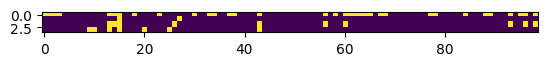

In [5]:
for batch in pbar(iter(tr)):
    if (batch['multilabel']*1.).mean() > 0.07:
        break
print ({k:len(v) for k,v in batch.items()})
plt.imshow(batch['multilabel'])
(batch['multilabel']*1.).mean()


 batch img 0:   amenity=* amenity=parking building=* building=apartments highway=* highway=track landuse=* landuse=brownfield landuse=commercial landuse=forest landuse=grass landuse=industrial landuse=residential leisure=* leisure=garden leisure=park leisure=pitch leisure=sports_centre leisure=track natural=* natural=grassland natural=scrub natural=water natural=wood parking=* parking=multi-storey parking=surface power=* power=generator power=substation sport=* sport=running sport=soccer surface=* surface=asphalt water=* water=canal water=pond water=reservoir water=wastewater waterway=* highway=motorway highway=residential waterway=stream

 batch img 1:   highway=* highway=track landuse=* landuse=military

 batch img 2:   highway=* highway=track landuse=* landuse=meadow natural=* natural=scrub natural=wood waterway=* highway=residential waterway=stream

 batch img 3:   crop=* crop=field_cropland highway=* highway=track landuse=* landuse=farmland landuse=farmyard landuse=industrial lan

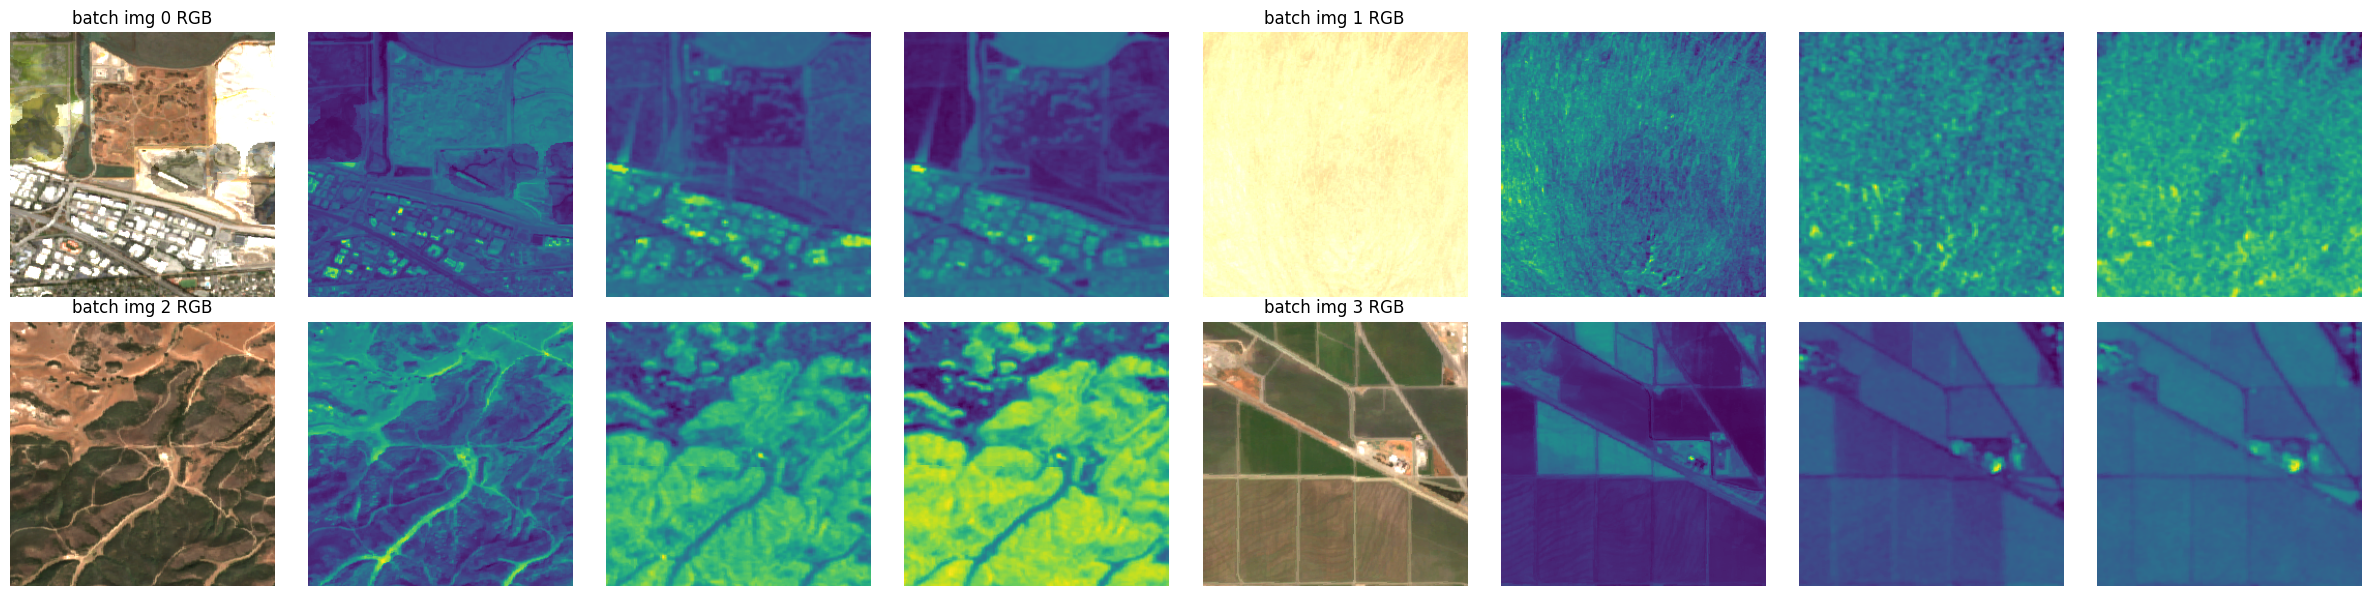

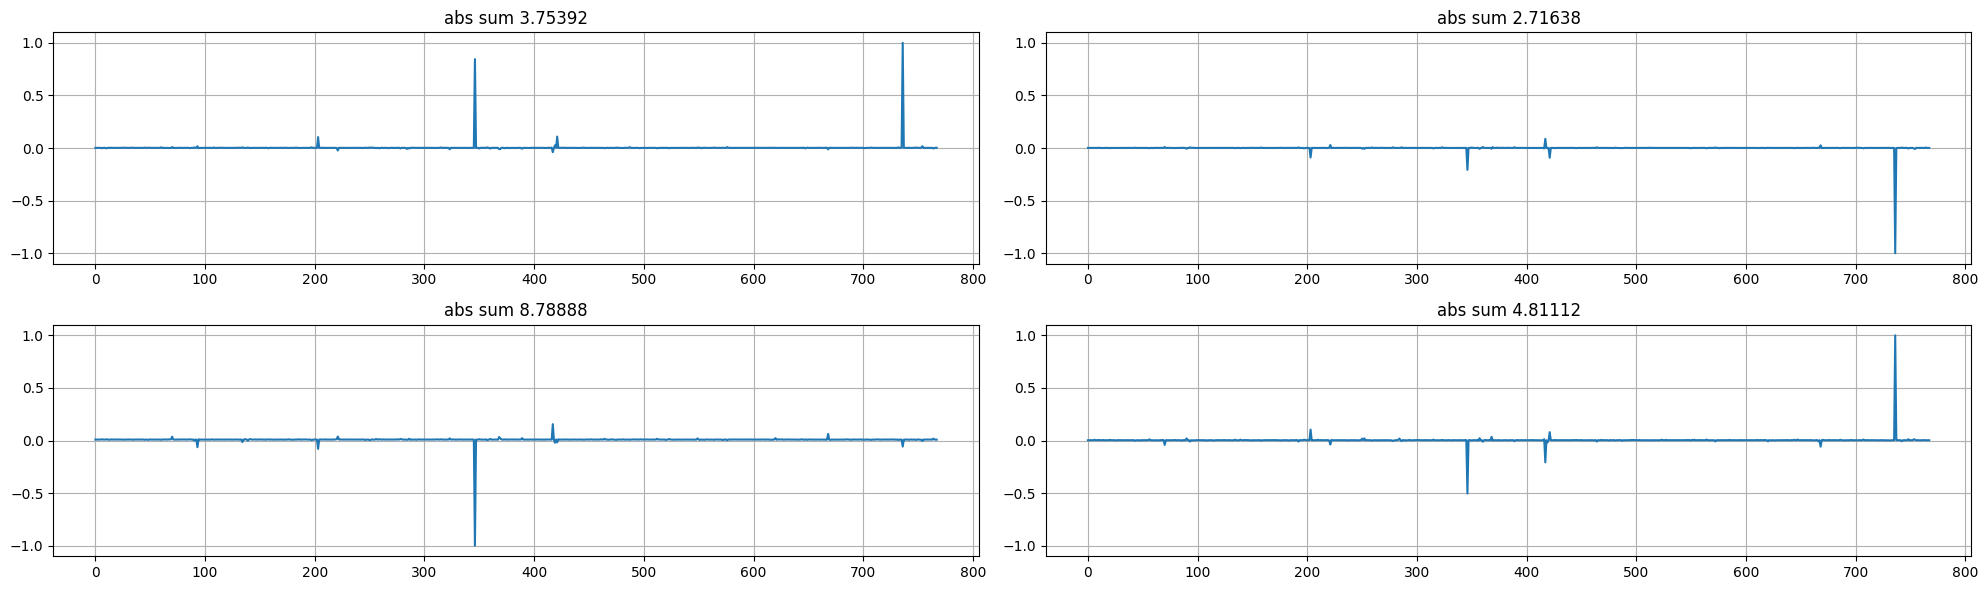

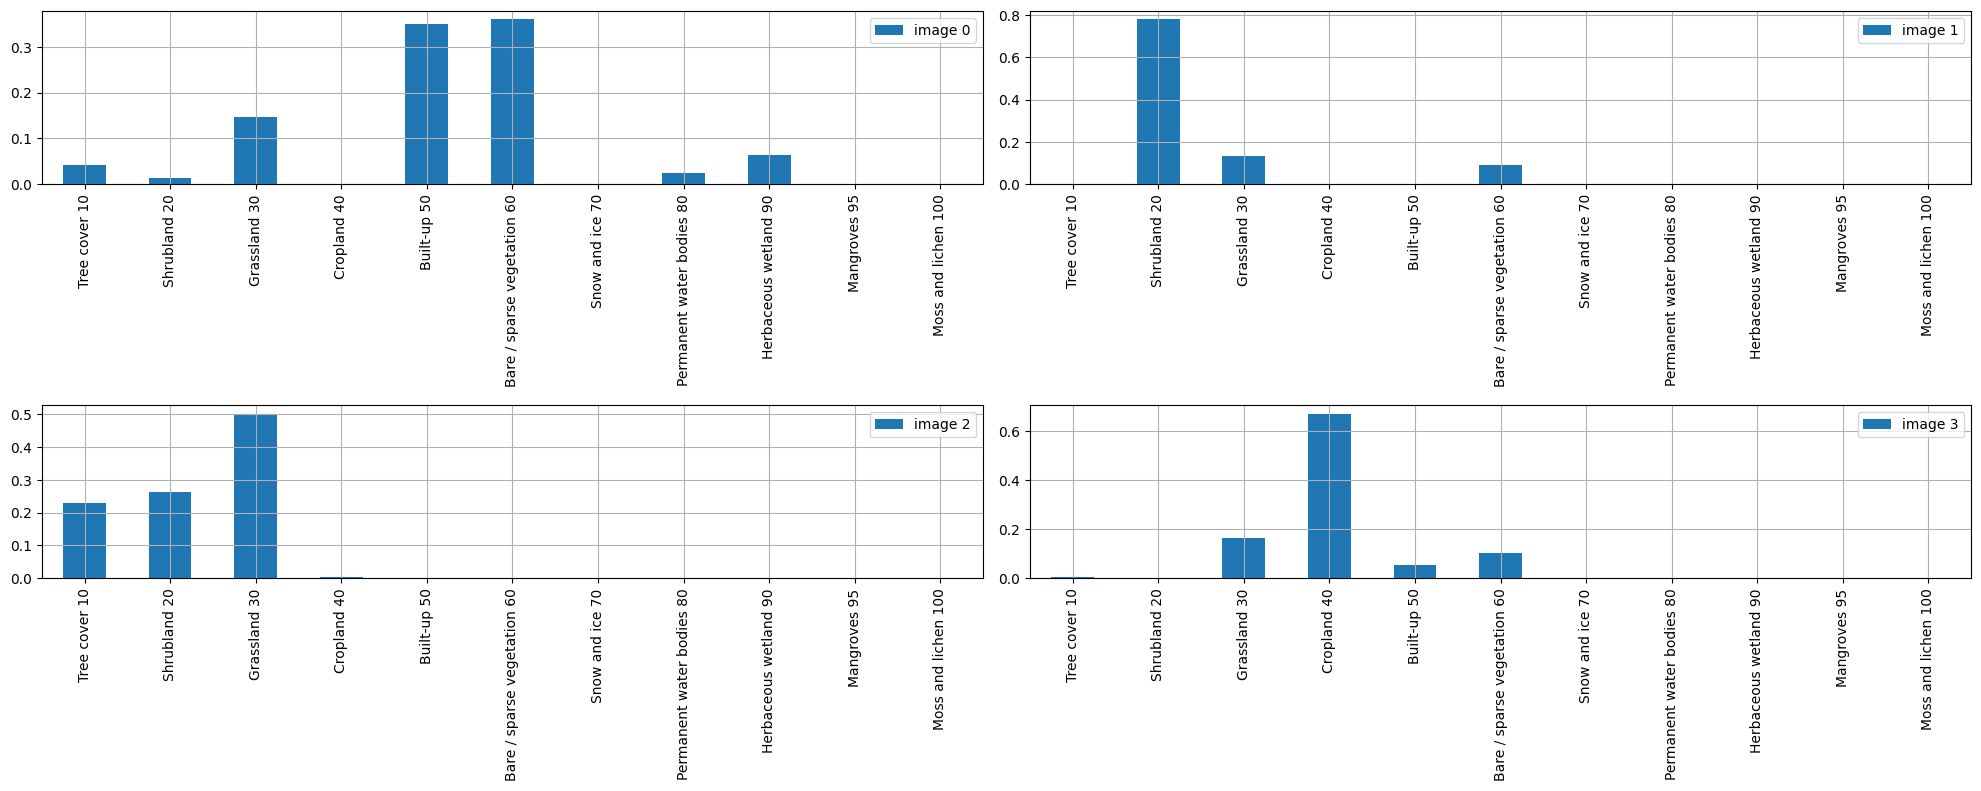

In [54]:
x = batch['chip']
imgs = []
titles = []
for i in range(len(x)):
    xi = x[i]
    print ("\n", f"batch img {i}:  ", batch['str_multilabel'][i])
    for ii in range(4):
        if ii==0:
            ximg = np.transpose(xi[:3], [1,2,0])
            ximg = ximg / 2000
            ximg[ximg>1] = 1
            imgs.append(ximg)
            titles.append(f"batch img {i} RGB")
        else:
            xii = xi[ii+2]
            a,b = np.percentile(xii, [1,99])
            xii = (xii-a)/(b-a)           

            imgs.append(xii)
            titles.append("")

# plot images
for ax,i in subplots(len(imgs), n_cols=8):
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(titles[i])

# plot embeddings
for ax,i in subplots(len(batch['embedding']), n_cols=2, usizex=10):
    xe = (batch['embedding'][i] / batch['embedding'].mean(axis=0)).numpy()
    xe = xe / np.max(np.abs(xe))
    plt.plot(xe)
    plt.title(f"abs sum {np.abs(xe).sum():.5f}")
    plt.grid()
    plt.ylim(-1.1,1.1)

# plot esawc proportions
ep = batch['esawc_proportions']
for ax,i in subplots(len(ep), n_cols=2, usizey=4, usizex=10):
    ei = ep[i]
    edf = pd.DataFrame([{k:v for k,v in eval(ei).items() if v>0}], index=[f'image {i}']).fillna(0).T
    
    # fill in missing classes, add text and order
    for k in esawc_map.keys():
        if not k in edf.index:
            edf.loc[k] = [0]
    idx = [str(j) for j in sorted([int(i) for i in edf.index])]
    edf = edf.loc[idx]
    edf.index = [f"{esawc_map[str(i)]} {i}" for i in edf.index]
    
    edf.plot(kind='bar', ax = ax)
    plt.grid();